In [64]:
import requests
import psycopg2
import polyline
import gpxpy
import json

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [48]:
OUTPUT_DIR = '../routes'

In [49]:
conn = psycopg2.connect(
    host="localhost",
    database="gpx",
    user="root",
    password="root"
)

In [50]:
query = """
WITH lines AS (
    SELECT
        b.name AS destination,
        a.latitude AS start_lat,
        a.longitude AS start_lon, 
        b.latitude AS stop_lat,
        b.longitude AS stop_lon,
        ST_MakeLine(
            ST_SetSRID(ST_MakePoint(a.longitude, a.latitude), 4326),
            ST_SetSRID(ST_MakePoint(b.longitude, b.latitude), 4326)
        ) AS geom
    FROM start a
    CROSS JOIN destinations b
),
points AS (
    SELECT
        id,
        latitude,
        longitude,
        ST_SetSRID(ST_MakePoint(longitude, latitude), 4326) AS geom
    FROM points_of_interest
)

SELECT
    destination,
    start_lat,
    start_lon,
    stop_lat,
    stop_lon,
    b.latitude,
    b.longitude,
    ST_Distance(
       ST_SetSRID(ST_MakePoint(start_lon, start_lat), 4326)::geography,
       ST_SetSRID(ST_MakePoint(stop_lon, stop_lat), 4326)::geography
    ) AS distance_to_destination,
    ST_Distance(
       ST_SetSRID(ST_MakePoint(start_lon, start_lat), 4326)::geography,
       b.geom::geography
    ) AS distance_to_point,
    ST_Distance(
        ST_Transform(b.geom, ST_SRID(a.geom))::geography,
        a.geom::geography
    ) AS distance_to_line_in_meters
FROM lines a
CROSS JOIN points b;
"""

with conn.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()

df = pd.DataFrame(rows, columns=[
    "destination",
    "start_lat", 
    "start_lon", 
    "stop_lat",
    "stop_lon",
    "point_lat",
    "point_lon",
    "distance_to_destination",
    "distance_to_point",
    "distance_to_line"
])

df.head(3)

,destination,start_lat,start_lon,stop_lat,stop_lon,point_lat,point_lon,distance_to_destination,distance_to_point,distance_to_line
0,Merlion,1.3096438,103.8966102,1.2869149,103.8547688,1.2981104,103.8699926,5291.511598,3225.150446,284.681816
1,Merlion,1.3096438,103.8966102,1.2869149,103.8547688,1.2992573,103.8712611,5291.511598,3045.940170,329.232245
2,Merlion,1.3096438,103.8966102,1.2869149,103.8547688,1.299257,103.8737869,5291.511598,2787.618704,195.690482


In [51]:
columns = ['destination', 'distance_to_destination', 'start_lat', 'start_lon', 'stop_lat', 'stop_lon']
grouped = df.groupby(columns)
closest_points = grouped.apply(lambda x: x.nsmallest(1, 'distance_to_line')).reset_index(drop=True)
closest_points = closest_points[
    (closest_points['distance_to_line'] < 1000)
    & (closest_points['distance_to_point'] < closest_points['distance_to_destination'])
]
closest_points = closest_points.groupby(columns).apply(
    lambda x: list(zip(x['point_lat'], x['point_lon']))
).reset_index()
closest_points.columns = ['destination', 'distance_to_destination', 'start_lat', 'start_lon', 'stop_lat', 'stop_lon', 'points']
closest_points

,destination,distance_to_destination,start_lat,start_lon,stop_lat,stop_lon,points
0,Bendemeer Home,2969.221222,1.3096438,103.8966102,1.3165826,103.8708364,"[(1.3096161, 103.8704609)]"
1,Benjamin Sheares Bridge,4628.418586,1.3096438,103.8966102,1.2869775,103.861647,"[(1.289113, 103.8647997)]"
2,Fort Canning Park,5796.541370,1.3096438,103.8966102,1.2918406,103.8476213,"[(1.2992573, 103.8712611)]"
3,Marina Barrage,4321.208849,1.3096438,103.8966102,1.2806791,103.8705445,"[(1.2879669, 103.8690283)]"
4,Marina Bay Cruise Center,6108.076159,1.3096438,103.8966102,1.2694073,103.8590068,"[(1.2769371, 103.8606031)]"
5,Marina Bay Financial Center,5585.913020,1.3096438,103.8966102,1.2821578,103.854498,"[(1.289113, 103.8647997)]"
6,Meadow,5074.571702,1.3096438,103.8966102,1.2795255,103.8622062,"[(1.2879669, 103.8690283)]"
7,Merlion,5291.511598,1.3096438,103.8966102,1.2869149,103.8547688,"[(1.3011868, 103.8808614)]"


In [87]:
def get_route(points):
    params = {
        'geometries': 'polyline6',
        'annotations': 'true'
    }
    response = requests.get(f"http://127.0.0.1:6000/route/v1/running/{points}", params=params)
    response.raise_for_status()
    route = response.json()
    return route['routes'][0]['geometry']

In [88]:
def create_gpx(coordinates, filename):
    gpx = gpxpy.gpx.GPX()
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)

    for coord in coordinates:
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(coord[0], coord[1]))

    with open(f"{OUTPUT_DIR}/{filename}.gpx", "w") as f:
        f.write(gpx.to_xml())

In [89]:
def plot_gpx(gpx_df, filename):
    plt.figure(figsize=(15, 8))
    plt.plot(gpx_df['longitude'], gpx_df['latitude'], color='red', label='Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.savefig(f"{OUTPUT_DIR}/{filename}.png")

103.8966102,1.3096438;103.8704609,1.3096161;103.8708364,1.3165826
103.8966102,1.3096438;103.8647997,1.289113;103.861647,1.2869775


/opt/homebrew/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


103.8966102,1.3096438;103.8712611,1.2992573;103.8476213,1.2918406
103.8966102,1.3096438;103.8690283,1.2879669;103.8705445,1.2806791


/opt/homebrew/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


103.8966102,1.3096438;103.8606031,1.2769371;103.8590068,1.2694073


/opt/homebrew/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


103.8966102,1.3096438;103.8647997,1.289113;103.854498,1.2821578


/opt/homebrew/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


103.8966102,1.3096438;103.8690283,1.2879669;103.8622062,1.2795255


/opt/homebrew/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


103.8966102,1.3096438;103.8808614,1.3011868;103.8547688,1.2869149


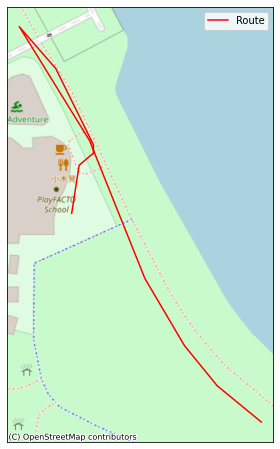

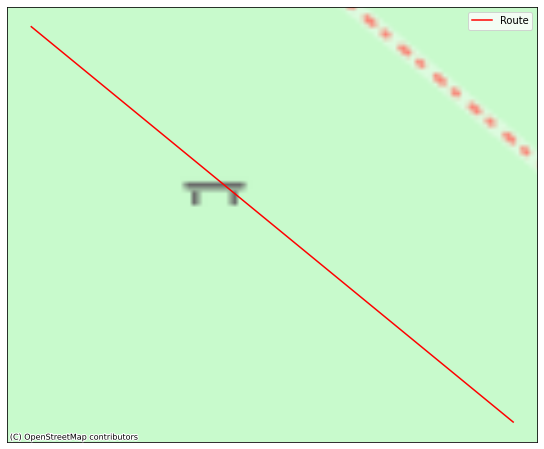

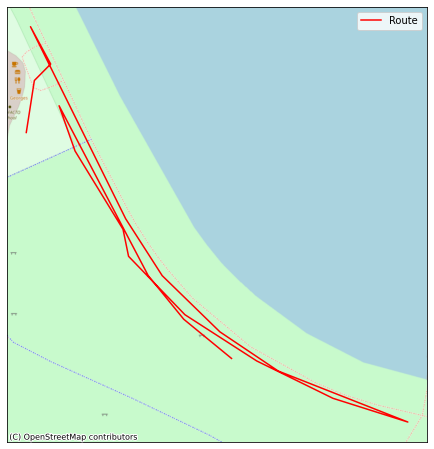

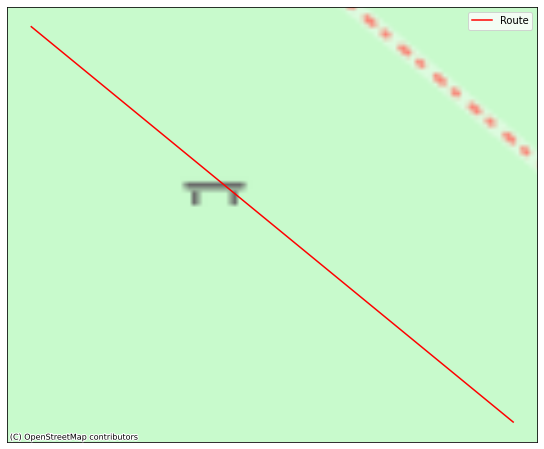

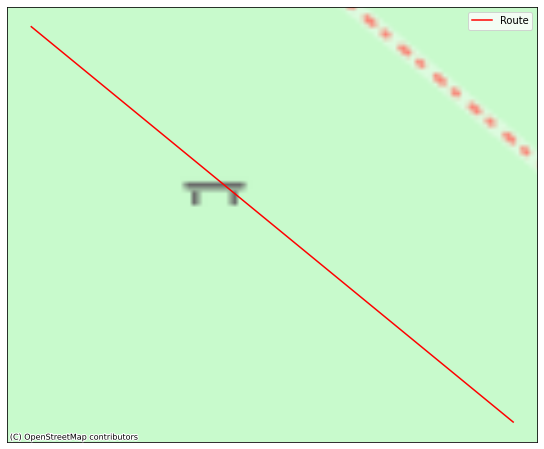

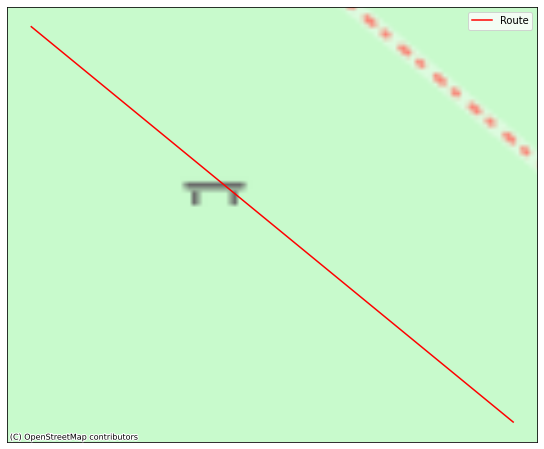

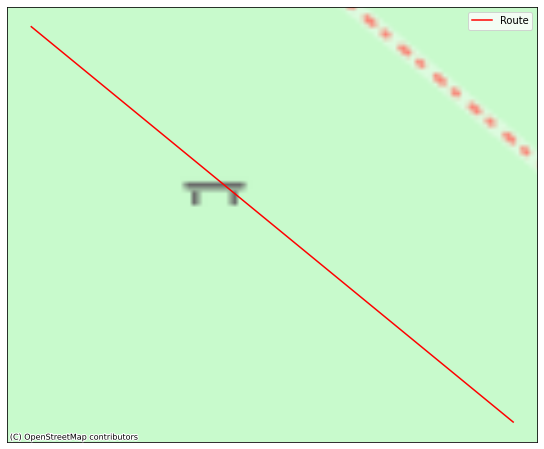

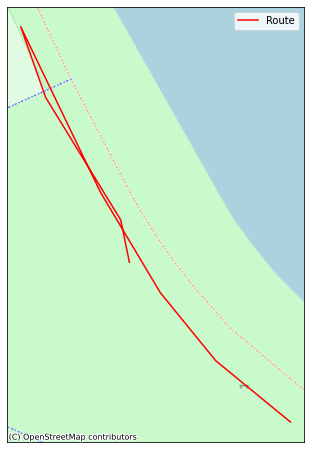

In [91]:
for index, row in closest_points.iterrows():
    intermediate_points = ';'.join([f"{lon},{lat}" for lat, lon in row['points']])
    points = f"{row['start_lon']},{row['start_lat']};{intermediate_points};{row['stop_lon']},{row['stop_lat']}"
    print(points)
    
    try:
        geometry = get_route(points)
        coordinates = polyline.decode(geometry, 6)

        gpx_df = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])
        plot_gpx(gpx_df, row['destination'])

        distance = round(row['distance_to_destination'] / 1000.0)
        filename = f"{row['destination']} ({distance}km)"
        create_gpx(coordinates, filename)
    except:
        continue